### 🌍 Install Required Libraries
This cell installs packages needed for data manipulation and geospatial visualization.

In [ ]:
!pip install pandas matplotlib numpy geopandas==0.14.4

### 📥 Load Emotion Embeddings
Load the main dataset that includes emotion annotations.

In [1]:
import pandas as pd 

qual_df = pd.read_parquet("emotion_embeddings.parquet")

emotions = qual_df["Emotion_button"].unique()



qual_df = qual_df.drop_duplicates(subset=["path"], keep="first")
qual_df.__len__()

qual_df.Ethnicity.unique()


array(['American Indian or Alaska Native',
       'white caucasian north american', 'Middle Eastern',
       'North African', 'Asian', 'White', 'South Asian',
       'white caucasian european', 'Hispanic or Latino',
       'Southeast Asian', 'arabic',
       'Native Hawaiian or Other Pacific Islander',
       'Black or African American', 'Indian'], dtype=object)

### 🧬 Ethnicity Label Mapping
Map ethnicities using the FairFace race categorization.

In [2]:
# -----------------------------------------------------------------
# Ethnicity → FairFace race
# -----------------------------------------------------------------
ETHNICITY_TO_FF = {
    # White
    'white caucasian european'        : 'White',
    'white caucasian north american'  : 'White',
    'White'                           : 'White',

    # Black
    'Black or African American'       : 'Black',

    # Latino
    'Hispanic or Latino'              : 'Latino',

    # East & Southeast Asian
    'Asian'                           : 'East Asian',
    'Southeast Asian'                 : 'Southeast Asian',

    # Indian / South-Asian bucket
    'Indian'                          : 'Indian',
    'South Asian'                     : 'Indian',

    # Middle-Eastern / North-African
    'Middle Eastern'                  : 'Middle Eastern',
    'arabic'                          : 'Middle Eastern',
    'North African'                   : 'Middle Eastern',

    # Indigenous & Pacific
    'American Indian or Alaska Native': 'AI/AN-NHPI',
    'Native Hawaiian or Other Pacific Islander': 'AI/AN-NHPI'
}
import pandas as pd

def add_fairface_race(path, out_path=None):
    """
    Read <path>, add a FairFace_Race column, and optionally
    write the enriched parquet to <out_path>.
    Returns the DataFrame so you can chain more work.
    """
    df = pd.read_parquet(path)

    # NB: assumes the source already contains an 'Ethnicity' column
    df['FairFace_Race'] = df['Ethnicity'].map(
        lambda x: ETHNICITY_TO_FF.get(x, 'Other')
    )

    if out_path is not None:
        df.to_parquet(out_path, index=False)

    return df
# enrich both files in-place (or write to new files if you prefer)

df_qual = add_fairface_race("emotion_embeddings_qual.parquet",
                            "emotion_embeddings_qual_with_race.parquet")

df_binary = add_fairface_race("emotion_embeddings.parquet",
                              "emotion_embeddings_binary_with_race.parquet")




### 📊 Preview Dataset
Display a preview of the dataset with race information.

In [4]:
pd.read_parquet("emotion_embeddings_qual_with_race.parquet").drop(columns=["image_path"]).head(5)

,prompt,Ethnicity,Age,Gender,Emotion,Emotion_list,Emotion_label,Emotion_button,siglip2_emb,FairFace_Race
0,"an authentic, realistic closeup image of a Asi...",Asian,70,woman,"contempt, disapproval, scorn, disdain, loathin...","[contempt, disapproval, scorn, disdain, loathi...",Contempt,Negative Low-Energy Emotions,"[0.084615916, -0.3438397, -0.42572138, -0.0958...",East Asian
1,"an authentic, realistic closeup image of a Asi...",Asian,70,woman,"contempt, disapproval, scorn, disdain, loathin...","[contempt, disapproval, scorn, disdain, loathi...",Contempt,Negative Low-Energy Emotions,"[0.2721719, -0.2219108, -0.4829932, 0.16069072...",East Asian
2,"an authentic, realistic closeup image of a Asi...",Asian,70,woman,"contempt, disapproval, scorn, disdain, loathin...","[contempt, disapproval, scorn, disdain, loathi...",Contempt,Negative Low-Energy Emotions,"[0.12929824, -0.29513502, -0.48463178, 0.03511...",East Asian
3,"an authentic, realistic closeup image of a Asi...",Asian,70,woman,"contempt, disapproval, scorn, disdain, loathin...","[contempt, disapproval, scorn, disdain, loathi...",Contempt,Negative Low-Energy Emotions,"[0.084615916, -0.3438397, -0.42572138, -0.0958...",East Asian
4,Very realistic high quality portrait DSLR phot...,Asian,20,man,genuine subtle mirth and silliness,[genuine subtle mirth and silliness],Amusement,Positive High-Energy Emotions,"[0.20500803, -0.3533018, -0.37408477, 0.136619...",East Asian


### 🧾 Check Unique Race Categories
Examine the distinct race categories in the dataset.

In [7]:
pd.read_parquet("emotion_embeddings_qual_with_race.parquet").FairFace_Race.unique()

array(['East Asian', 'Latino', 'AI/AN-NHPI', 'Black', 'White',
       'Southeast Asian', 'Middle Eastern', 'Indian'], dtype=object)

### 🗺️ Load Geospatial Libraries
Import geospatial and plotting libraries for map generation and create world map

/pfss/mlde/workspaces/mlde_wsp_P_HessianEuropeLLM/m_home/tmp/ipykernel_9275/3952247343.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'), engine="pyogrio")


Successfully loaded and processed emotion data from: emotion_embeddings_qual_with_race.parquet


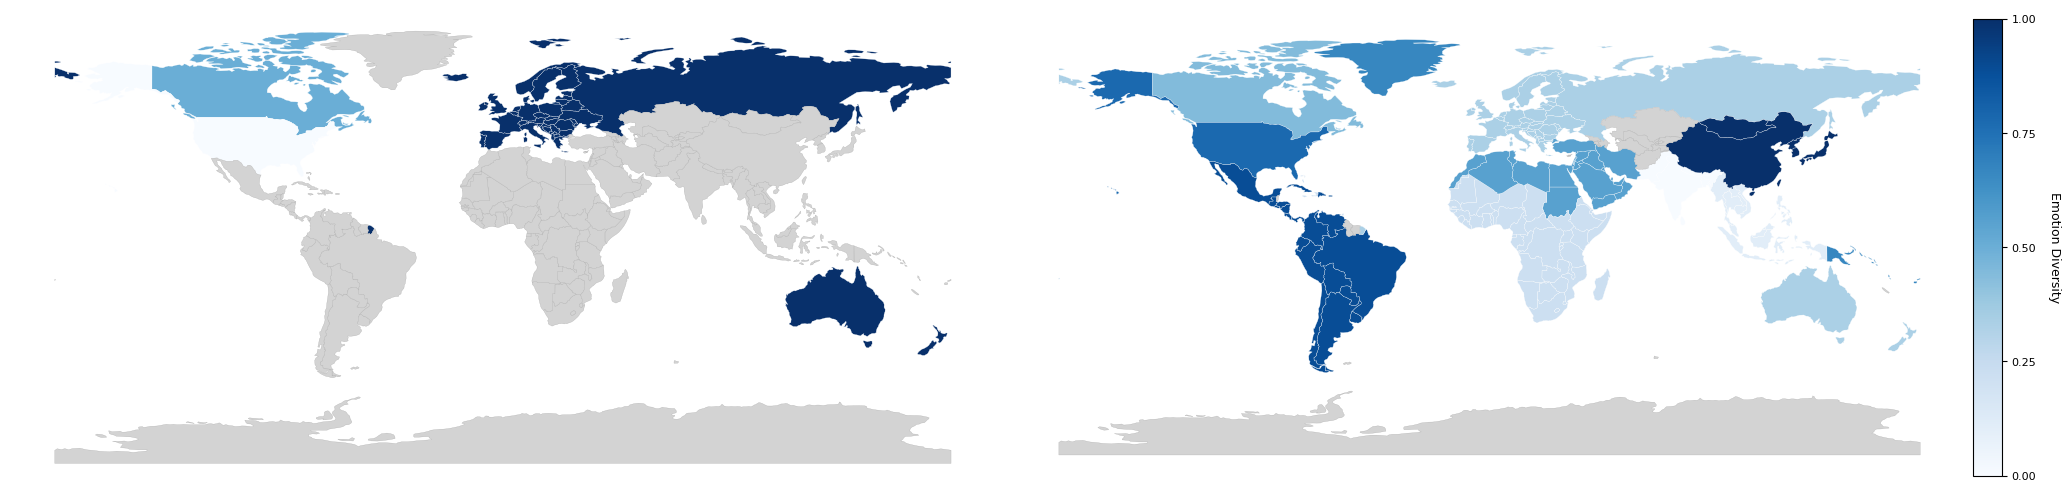

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ---------------------------------------------------------------
# 1)  LOAD & EXPLODE WORLD GEOMETRY
# ---------------------------------------------------------------
world = (
    gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'), engine="pyogrio")
        .explode(ignore_index=True)
)
world = world.rename(columns={'iso_a3': 'CODE'})

# ---------------------------------------------------------------
# 2)  RACE → ISO-3 COUNTRY SETS  (your definitions)
# ---------------------------------------------------------------
RACE_TO_ISO = { # This definition is used for BOTH plots
    'White': {
        *set(world.loc[world.continent == 'Europe', 'CODE']),
        'USA', 'CAN', 'AUS', 'NZL'
    },
    'Black': {
        *(
            set(world.loc[world.continent == 'Africa', 'CODE'])
            - {'DZA', 'MAR', 'TUN', 'LBY', 'EGY', 'SDN'}
        ),
        'JAM', 'TTO', 'HTI', 'BRB', 'BHS', 'ATG', 'KNA', 'LCA', 'VCT', 'GRD', 'DMA'
    },
    'Latino': {
        'MEX', 'GTM', 'HND', 'SLV', 'NIC', 'CRI', 'PAN',
        'CUB', 'DOM', 'PRI',
        'COL', 'VEN', 'ECU', 'PER', 'BOL', 'PRY',
        'BRA', 'CHL', 'ARG', 'URY',
        'USA'
    },
    'East Asian'      : {'CHN', 'TWN', 'JPN', 'PRK', 'KOR', 'MNG'},
    'Southeast Asian' : {'IDN', 'THA', 'VNM', 'MYS', 'SGP', 'PHL', 'MMR',
                         'KHM', 'LAO', 'BRN', 'TLS'},
    'Indian'          : {'IND', 'PAK', 'BGD', 'NPL', 'LKA', 'BTN', 'MDV'},
    'Middle Eastern'  : {
        'SAU', 'ARE', 'OMN', 'YEM', 'QAT', 'BHR', 'KWT',
        'IRQ', 'JOR', 'LBN', 'SYR', 'ISR', 'PSE',
        'TUR', 'IRN',
        'DZA', 'MAR', 'TUN', 'LBY', 'EGY', 'SDN'
    },
    'AI/AN-NHPI'      : {
        'GRL', 'USA', 'CAN',
        'PNG', 'FJI', 'WSM', 'SLB', 'VUT', 'KIR', 'MHL', 'PLW',
        'NRU', 'TON', 'TUV', 'FSM'
    }
}

PARQUET_PATH = "emotion_embeddings_qual_with_race.parquet"
RACE_COL, EMOTION_COL = "FairFace_Race", "Emotion_button"
divers = None

try:
    df_emotion = pd.read_parquet(PARQUET_PATH)
    freq_emotion = df_emotion.groupby([RACE_COL, EMOTION_COL]).size().unstack(fill_value=0)
    prop_emotion = freq_emotion.div(freq_emotion.sum(axis=1), axis=0)
    divers = prop_emotion.var(axis=1)
    print(f"Successfully loaded and processed emotion data from: {PARQUET_PATH}")
except FileNotFoundError:
    print(f"WARNING: Parquet file not found at '{PARQUET_PATH}'. The right map will show missing data.")
except Exception as e:
    print(f"WARNING: Error processing parquet file '{PARQUET_PATH}': {e}. The right map will show missing data.")


representation_data_left_plot = {
    'White': 1.0,
    'East Asian': 0.0,
    'Indian': 0.0,
    'Latino': 0.0,
    'Black': 0.0,
    'Middle Eastern': 0.0,
    'Southeast Asian': 0.0,
    'AI/AN-NHPI': 0.0
}
representation_scores_left_plot = pd.Series(representation_data_left_plot)


def mean_diversity_right_plot(iso):
    if divers is not None:
        vals = [divers.get(r) for r, bag in RACE_TO_ISO.items() if iso in bag]
        vals = [v for v in vals if pd.notna(v)]
        return sum(vals) / len(vals) if vals else pd.NA
    return pd.NA

world['diversity_right'] = world['CODE'].apply(mean_diversity_right_plot)

if world['diversity_right'].notna().any():
    min_div = world['diversity_right'].min()
    max_div = world['diversity_right'].max()
    if pd.notna(min_div) and pd.notna(max_div) and min_div != max_div:
        world['div_norm_right'] = (world['diversity_right'] - min_div) / (max_div - min_div)
    elif pd.notna(min_div):
        world['div_norm_right'] = 0.5
    else:
        world['div_norm_right'] = pd.NA
else:
    world['div_norm_right'] = pd.NA


def mean_representation_left_plot(iso):
    vals = [representation_scores_left_plot.get(r) for r, bag in RACE_TO_ISO.items() if iso in bag]
    vals = [v for v in vals if pd.notna(v)]
    if not vals:
        return pd.NA
    return sum(vals) / len(vals)

world['representation_score_left'] = world['CODE'].apply(mean_representation_left_plot)

if world['representation_score_left'].notna().any():
    valid_scores = world['representation_score_left'].dropna()
    if not valid_scores.empty:
        min_rep = valid_scores.min()
        max_rep = valid_scores.max()
        if min_rep == max_rep:
            world['rep_norm_left'] = 0.0 if min_rep == 0.0 else 0.5
        else:
            denominator = max_rep - min_rep
            world['rep_norm_left'] = (world['representation_score_left'] - min_rep) / denominator
    else:
        world['rep_norm_left'] = pd.NA
else:
    world['rep_norm_left'] = pd.NA


fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True) # constrained_layout helps fit colorbar


left_ax = axes[0]
plot_data_left = world.copy()
plot_data_left['rep_norm_left_for_plot'] = plot_data_left['rep_norm_left']
is_zero_mask_left = plot_data_left['rep_norm_left'].eq(0.0).fillna(False)
plot_data_left.loc[is_zero_mask_left, 'rep_norm_left_for_plot'] = pd.NA


plot_data_left.plot(
    ax=left_ax,
    column='rep_norm_left_for_plot',
    cmap='Blues',
    linewidth=0.2,
    edgecolor='white',
    legend=False,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "darkgrey",
    }
)
left_ax.set_aspect('equal')
left_ax.axis('off')


right_ax = axes[1]
plot_data_right = world.copy()
plot_data_right['div_norm_right'] = plot_data_right['div_norm_right'].fillna(pd.NA)


plot_data_right.plot(
    ax=right_ax,
    column='div_norm_right',
    cmap='Blues',
    linewidth=0.2,
    edgecolor='white',
    legend=False,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "darkgrey",
    }
)
right_ax.set_aspect('equal')
right_ax.axis('off')


norm_left = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
sm_left = mpl.cm.ScalarMappable(cmap='Blues', norm=norm_left)
sm_left.set_array([]) # Important for ScalarMappable


divider_colorbar = make_axes_locatable(right_ax)
cax_colorbar = divider_colorbar.append_axes("right", size="3%", pad=0.1) # Adjusted pad slightly

cb = plt.colorbar(sm_left, cax=cax_colorbar, ticks=[0, 0.25, 0.5, 0.75, 1.0])
cb.set_label("Emotion Diversity", rotation=270, labelpad=18, fontsize=9)
cb.ax.tick_params(labelsize=8)
# plt.tight_layout()
plt.savefig("Emotion_diversity.pdf")